<a href="https://colab.research.google.com/github/keehyun2/TestPy/blob/master/colab/5-3-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 트리의 앙상블

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 랜덤포레스트

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [ ]:
print(target)

[0. 0. 0. ... 1. 1. 1.]


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
# rf = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=15, min_impurity_decrease=0.001)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8705025211159443 0.8624222625305397


In [ ]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.14751273 0.62020033 0.23228694]


Text(0.5, 1.0, 'Random Forest Feature Importances')

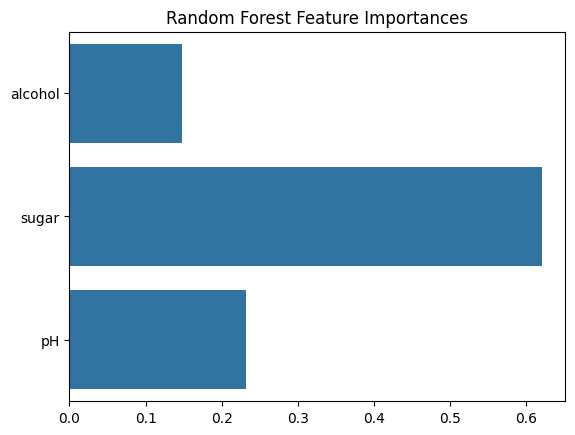

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 시각화
sns.barplot(x=rf.feature_importances_, y=['alcohol', 'sugar', 'pH'])
plt.title('Random Forest Feature Importances')

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


## 엑스트라트리

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
# et = ExtraTreesClassifier(n_jobs=-1, random_state=42, max_depth=15, min_impurity_decrease=0.001)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.7579372773984272 0.7579373658103206


In [ ]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.17566683 0.26266598 0.56166718]


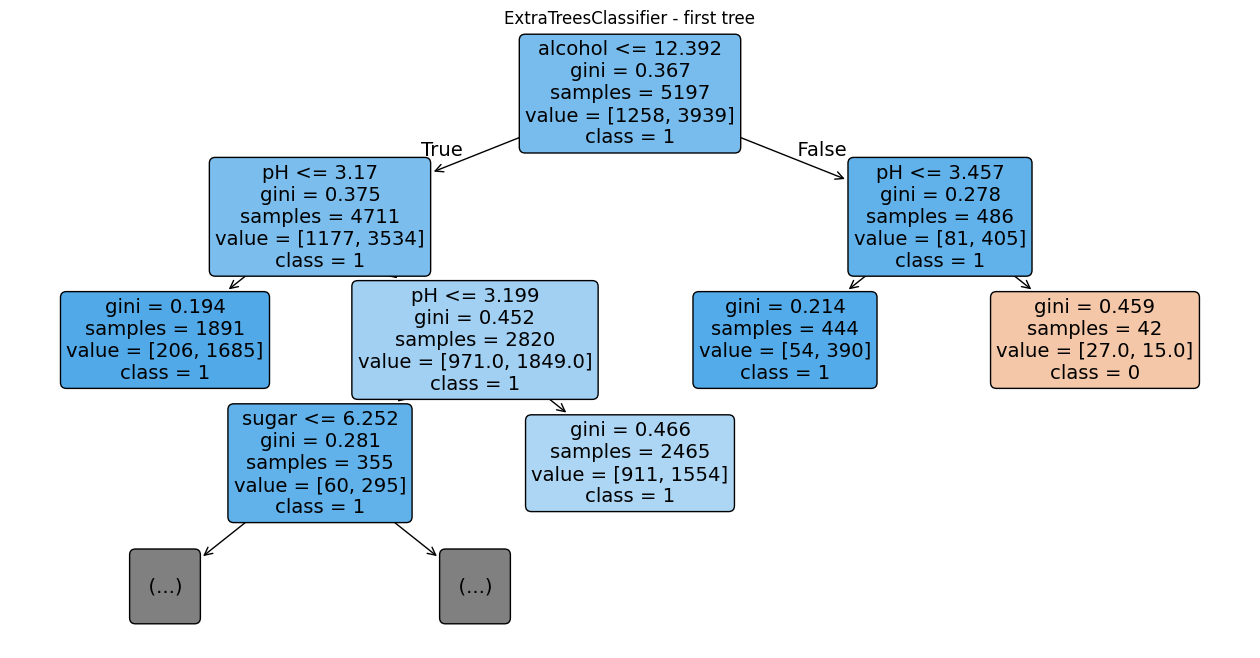

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 첫 번째 트리 시각화
plt.figure(figsize=(16, 8))
plot_tree(et.estimators_[0],
          feature_names=['alcohol', 'sugar', 'pH'],
          class_names=['0','1'],
          filled=True,
          rounded=True,
          max_depth=3)
plt.title("ExtraTreesClassifier - first tree")
plt.show()

In [ ]:
# 각 트리의 깊이 비교
rf_depths = [tree.tree_.max_depth for tree in rf.estimators_]
et_depths = [tree.tree_.max_depth for tree in et.estimators_]

print("RandomForest 평균 깊이:", np.mean(rf_depths))
print("ExtraTrees 평균 깊이:", np.mean(et_depths))


RandomForest 평균 깊이: 21.46
ExtraTrees 평균 깊이: 0.67


## 그레이디언트 부스팅

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [ ]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


In [ ]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15887763 0.6799705  0.16115187]


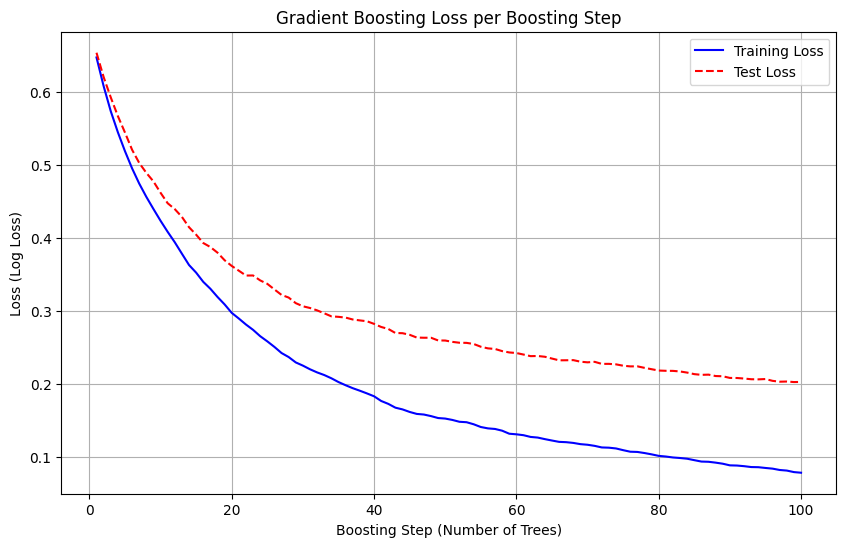

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification # 예시 데이터 생성용

# 1. 예시 데이터 생성 (실제 데이터로 대체하세요)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. GradientBoostingClassifier 초기화 및 학습
# n_estimators는 부스팅 단계의 최대 개수
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# 3. 각 부스팅 단계별 손실 계산 및 저장
train_losses = []
test_losses = []

# staged_decision_function은 각 단계별 예측 점수를 반환합니다.
# 이진 분류의 경우 (n_classes = 2), decision_function은 1차원 배열입니다.
# 다중 클래스 분류의 경우, 각 클래스별 점수가 나옵니다.
for i, y_pred_stage in enumerate(gb.staged_decision_function(X_train)):
    # scikit-learn의 log_loss는 확률(proba)을 입력으로 받습니다.
    # decision_function 값을 확률로 변환 (sigmoid for binary classification)
    # y_pred_stage는 로짓(logit) 값이므로 시그모이드를 적용하여 확률로 변환합니다.
    y_proba_stage = 1 / (1 + np.exp(-y_pred_stage))
    train_losses.append(log_loss(y_train, y_proba_stage))

for i, y_pred_stage in enumerate(gb.staged_decision_function(X_test)):
    y_proba_stage = 1 / (1 + np.exp(-y_pred_stage))
    test_losses.append(log_loss(y_test, y_proba_stage))


# 4. 손실 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, gb.n_estimators + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, gb.n_estimators + 1), test_losses, label='Test Loss', color='red', linestyle='--')
plt.title('Gradient Boosting Loss per Boosting Step')
plt.xlabel('Boosting Step (Number of Trees)')
plt.ylabel('Loss (Log Loss)')
plt.legend()
plt.grid(True)
plt.show()

# OOB (Out-of-Bag) Improvement를 통해 손실 감소를 보는 방법 (선택 사항)
# gb.oob_improvement_는 각 단계에서 OOB 샘플에 대한 손실 감소량을 저장합니다.
# 누적 손실은 OOB_improvement_의 음수 누적합으로 근사할 수 있습니다.
# (단, oob_improvement_는 모델 초기화 시 subsample=True로 설정해야 유효합니다.)
if gb.subsample < 1.0: # subsample 파라미터가 설정되어 있을 때만 유효
    initial_loss = log_loss(y_train, gb.predict_proba(X_train)[:, 1]) # 또는 다른 방법으로 초기 손실 추정
    oob_losses = np.array([initial_loss] + list(initial_loss - np.cumsum(gb.oob_improvement_)))
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(oob_losses)), oob_losses, label='OOB Loss Approximation', color='green')
    plt.title('Gradient Boosting OOB Loss Approximation')
    plt.xlabel('Boosting Step (Number of Trees)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## 히스토그램 기반 부스팅

In [ ]:
# 사이킷런 1.0 버전 아래에서는 다음 라인의 주석을 해제하고 실행하세요.
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


In [ ]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [ ]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [ ]:
hgb.score(test_input, test_target)

0.8723076923076923

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9558403027491312 0.8782000074035686


#### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884


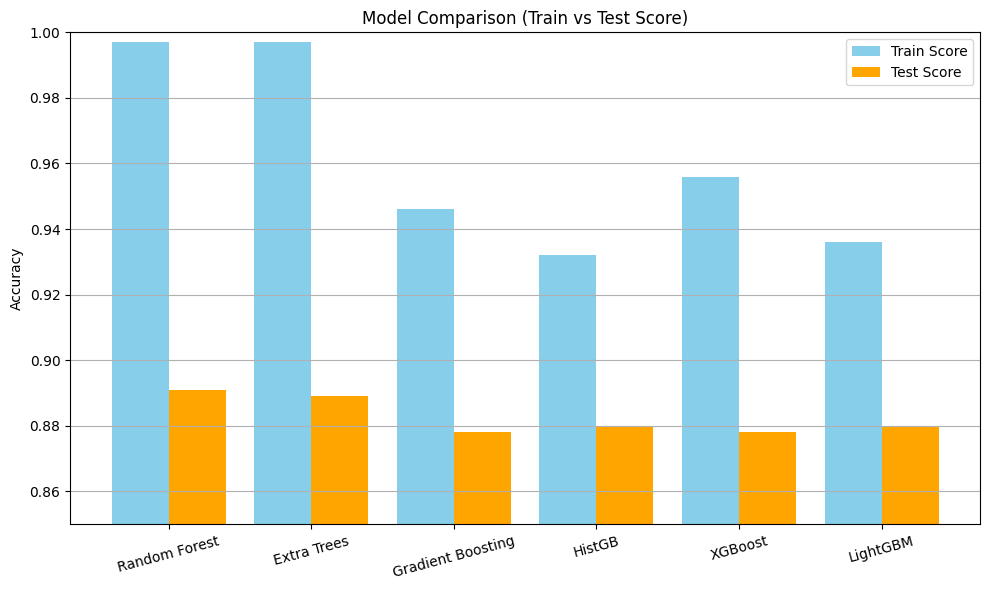

In [ ]:
import matplotlib.pyplot as plt

# 평균 교차검증 점수 (예시용 수동 입력, 실제는 각 모델 실행 후 저장)
model_names = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'HistGB', 'XGBoost', 'LightGBM']
train_scores = [0.997, 0.997, 0.946, 0.932, 0.956, 0.936]  # np.mean(scores['train_score']) 값들
test_scores = [0.891, 0.889, 0.878, 0.880, 0.878, 0.880]   # np.mean(scores['test_score']) 값들

x = np.arange(len(model_names))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_scores, width=0.4, label='Train Score', color='skyblue')
plt.bar(x + 0.2, test_scores, width=0.4, label='Test Score', color='orange')
plt.xticks(x, model_names, rotation=15)
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.title('Model Comparison (Train vs Test Score)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


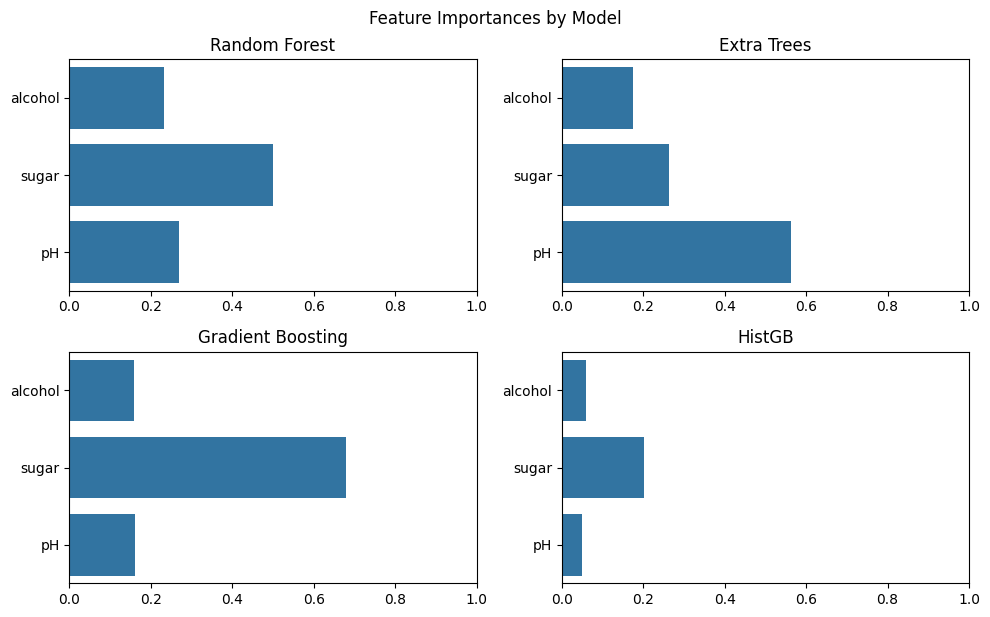

In [ ]:
feature_names = ['alcohol', 'sugar', 'pH']
importances = {
    'Random Forest': rf.feature_importances_,
    'Extra Trees': et.feature_importances_,
    'Gradient Boosting': gb.feature_importances_,
    'HistGB': result.importances_mean[:3]  # perm. importance
}

plt.figure(figsize=(10, 6))
for i, (name, imp) in enumerate(importances.items()):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=imp, y=feature_names)
    plt.title(name)
    plt.xlim(0, 1)
    plt.tight_layout()
plt.suptitle("Feature Importances by Model", y=1.02)
plt.show()
